In [1]:
import numpy as np
import os
import copy
import shutil
import matplotlib.pyplot as plt

import falco
import proper

import misc

# from roman.EXAMPLE_config_Roman_CGI_HLC_NFOV_Band1 import mp
from EXAMPLE_config_Roman_CGI_SPC_Bowtie_Band3 import mp

/home/u21/kianmilani/src/pyfalco/falco/config


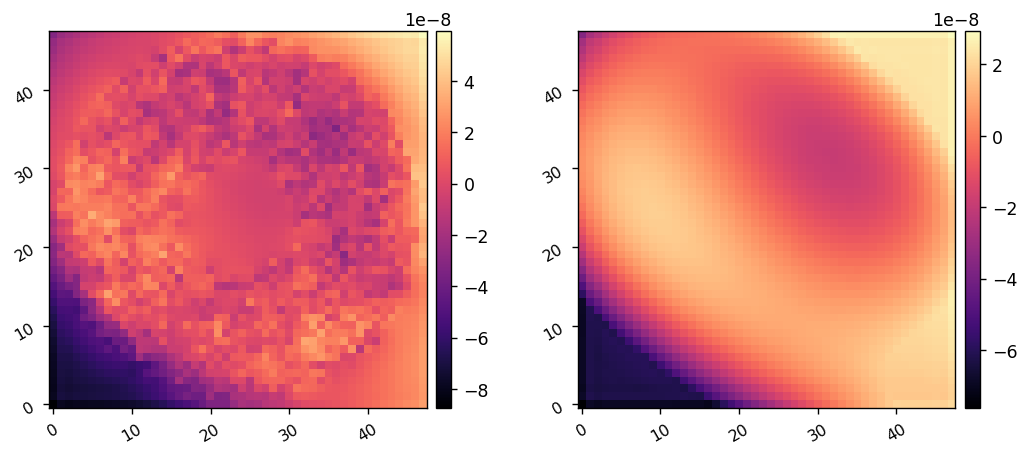

In [2]:
misc.myimshow2(mp.full.dm1.flatmap, mp.full.dm2.flatmap,) 


In [3]:
# %% Overwrite values from config file if desired

# ## Special Computational Settings
mp.flagPlot = True
mp.flagParallel = False  # whether to use multiprocessing to parallelize some large computations
# mp.Nthreads = 2  # Number of threads to use when using multiprocessing.

# Record Keeping
mp.TrialNum = 1
mp.SeriesNum = 1

# %% SETTINGS FOR QUICK RUN: SINGLE WAVELENGTH, SINGLE POLARIZATION, AND NO PROBING

mp.fracBW = 0.01  # fractional bandwidth of the whole bandpass (Delta lambda / lambda0)
mp.Nsbp = 1  # Number of sub-bandpasses to divide the whole bandpass into for estimation and control
mp.Nwpsbp = 1  # Number of wavelengths to used to approximate an image in each sub-bandpass
mp.full.pol_conds = [10, ]
mp.estimator = 'perfect'
mp.flagParallel = False  # whether to use multiprocessing to parallelize some large computations

In [4]:
# %% Keep only the central bandpasses's FPM if using just one wavelength with HLC
if (mp.Nsbp == 1) and (mp.coro == 'HLC'):
    n = mp.compact.fpmCube.shape[0]
    nSlices = mp.compact.fpmCube.shape[2]
    mp.compact.fpmCube = mp.compact.fpmCube[:, :, nSlices//2].reshape((n, n, 1))

In [5]:
# %% Perform an idealized phase retrieval (get the E-field directly)
optval = copy.copy(mp.full)
optval.source_x_offset = 0
optval.use_dm1 = True
optval.use_dm2 = True
nout = 1024
optval.output_dim = 1024
optval.use_fpm = False
optval.use_pupil_mask = False  # No SPM for getting initial phase
optval.use_lyot_stop = False
optval.use_field_stop = False
optval.use_pupil_lens = True
delattr(optval, 'final_sampling_lam0')

# Use non-SPC flat maps for SPC since SPM has separate aberrations
# downstream that can't be fully captured at entrance pupil with the SPM in
# place. The SPM aberrations are flattened in a separate step not included
# here.
if 'sp' in mp.coro.lower():
    optval.dm1_m = mp.full.dm1.flatmapNoSPM
    optval.dm2_m = mp.full.dm2.flatmapNoSPM
else:
    optval.dm1_m = mp.full.dm1.flatmap
    optval.dm2_m = mp.full.dm2.flatmap

if mp.Nsbp == 1:
    lambdaFacs = np.array([1.])
else:
    lambdaFacs = np.linspace(1-mp.fracBW/2, 1+mp.fracBW/2, mp.Nsbp)

In [6]:
# Get the Input Pupil's E-field
nCompact = falco.util.ceil_even(mp.P1.compact.Nbeam + 1)
mp.P1.compact.E = np.ones((nCompact, nCompact, mp.Nsbp), dtype=complex)
for iSubband in range(mp.Nsbp):

    lambda_um = 1e6*mp.lambda0*lambdaFacs[iSubband]

    # Get aberrations for the full optical train
    optval.pinhole_diam_m = 0  # 0 means don't use the pinhole at FPAM
    fieldFullAll, sampling = proper.prop_run('roman_phasec', lambda_um, nout, QUIET=True,
                                             PASSVALUE=optval.__dict__)

    # Put pinhole at FPM to get back-end optical aberrations
    optval.pinhole_diam_m = mp.F3.pinhole_diam_m;
    fieldFullBackEnd, sampling = proper.prop_run('roman_phasec', lambda_um, nout, QUIET=True, 
                                                 PASSVALUE=optval.__dict__)
    optval.pinhole_diam_m = 0  # 0 means don't use the pinhole at FPAM

    # Subtract off back-end phase aberrations from the phase retrieval estimate
    phFrontEnd = np.angle(fieldFullAll) - np.angle(fieldFullBackEnd)
    # swMask = ampthresh(fieldFullAll)
    # phFrontEnd, _ = removeZernikes(phFrontEnd, [0 1 1], [0 1 -1], swMask)  # Remove tip/tilt/piston

    # Put front-end E-field into compact model
    fieldFull = np.abs(fieldFullAll) * np.exp(1j*phFrontEnd)
    fieldCompactReal = falco.mask.rotate_shift_downsample_pupil_mask(
        np.real(fieldFull), mp.P1.full.Nbeam, mp.P1.compact.Nbeam, 0, 0, 0)
    fieldCompactImag = falco.mask.rotate_shift_downsample_pupil_mask(
        np.imag(fieldFull), mp.P1.full.Nbeam, mp.P1.compact.Nbeam, 0, 0, 0)
    fieldCompact = fieldCompactReal + 1j*fieldCompactImag
    fieldCompact = falco.util.pad_crop(fieldCompact, (nCompact, nCompact))
    mp.P1.compact.E[:, :, iSubband] = falco.prop.relay(fieldCompact, 1, centering=mp.centering)

    if mp.flagPlot:
        plt.figure(11); plt.imshow(np.angle(fieldCompact)); plt.colorbar(); plt.hsv(); plt.pause(1e-2)
        plt.figure(12); plt.imshow(np.abs(fieldCompact)); plt.colorbar(); plt.magma(); plt.pause(0.5)

KeyboardInterrupt: 

In [ ]:
# Don't double count the pupil amplitude with the phase retrieval and a model-based mask
mp.P1.compact.mask = np.ones_like(mp.P1.compact.mask)


In [7]:
# %% Generate the label associated with this trial
mp.runLabel = ('spc_bowtie_band3_trial01.pkl')
print(mp.runLabel)

Series0001_Trial0001_HLC


 Using 1 discrete wavelength(s) in each of 1 sub-bandpasses over a 1.0% total bandpass 

Sub-bandpasses are centered at wavelengths [nm]:	 [575.]


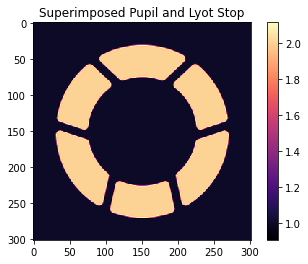

  Influence function padded from 84 to 84 points for A.S. propagation.
Computing datacube of DM influence functions... done.
  Influence function padded from 84 to 84 points for A.S. propagation.
Computing datacube of DM influence functions... done.


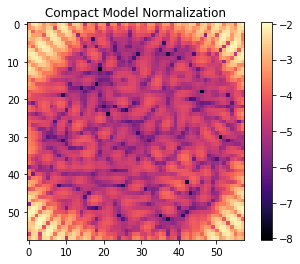

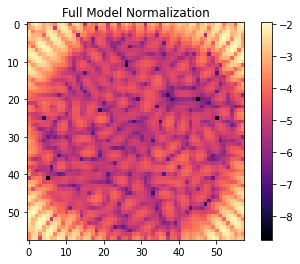


Beginning Trial 1 of Series 1.

DM 1-to-2 Fresnel number (using radius) = 932.0391304347827


In [8]:
# setup the workspace
out = falco.setup.flesh_out_workspace(mp)

In [ ]:
# %% Perform the Wavefront Sensing and Control

falco.wfsc.loop(mp, out)


In [ ]:
# %% Plot the output
falco.plot.plot_trial_output(out)

# Or, load and plot the output data from pickled data
fnPickle = os.path.join(mp.path.brief, (mp.runLabel + '_snippet.pkl'))
falco.plot.plot_trial_output_from_pickle(fnPickle)